**Caderno referente ao projeto da disciplina Sistemas de Controle II - UFRN.**

### Grupo de Trabalho
* Christian Erick Andrade Paiva
* Ianca Maria Leite da Costa
* José Adriano Brito de Lima

## Configuração do ambiente

In [1]:
#!pip install control

In [2]:
from numpy import * # package for numerical calculations
from pylab import * # package for graphics
from control import * # package for control theory calculations
from control.matlab import * # package for control theory calculations
ion() # display graphics automatically

## Definição do sistema

In [3]:
sys = tf([2], [1, 0.5, 0]) # Define a transfer function
sys


     2
-----------
s^2 + 0.5 s

Diagrama de polos e zeros

(array([-0.5,  0. ]), array([], dtype=float64))

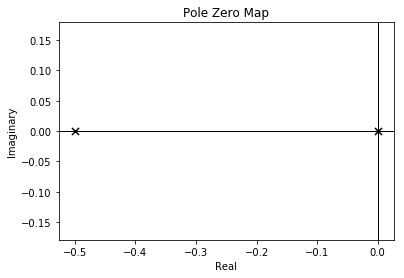

In [4]:
pzmap(sys)

Curvas de Bode

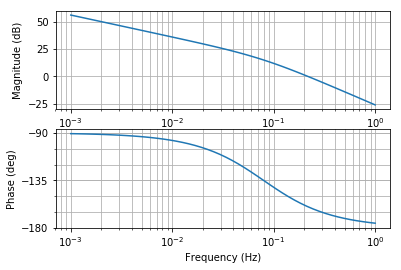

In [5]:
mag, phase, omega = bode(sys)

Extraindo os **parâmetros** frequenciais: margem de fase, margem de ganho, frequência de cruzamento de ganho e frequência de cruzamento de fase

In [6]:
gm, pm, wg, wp = margin(sys)

Margem de ganho **infinita**

In [7]:
gm

inf

Margem de fase

In [8]:
pm

20.040400498694623

Frequência para a margem de ganho

In [9]:
wg

nan

Frequência para a margem de fase

In [10]:
wp

1.3707306236949603

## 1. Projeto do Controlador - Método Frequencial


**Requisitos do sistema após a inserção do controlador:** <br> <br>
**gm** -> 6dB <br>
**pm** -> 70 graus <br>
**wp** -> 1.4

In [11]:
sys


     2
-----------
s^2 + 0.5 s

In [12]:
pm_new = 70

In [13]:
wp_new = 1.4

Fase [rad] do sistema para a w=1.4

In [14]:
sys_3j = evalfr(sys, 1.4j)
sys_3j

(-0.9049773755656109-0.32320620555914675j)

In [15]:
new_phase = np.angle(sys_3j)
new_phase

-2.79856871316909

In [16]:
G_sys_3j = 20*np.log10(np.abs(sys_3j))
G_sys_3j

-0.34588353713624354

In [17]:
sys


     2
-----------
s^2 + 0.5 s

Fase em graus

In [18]:
new_phase = np.angle(sys_3j,deg=True)
new_phase

-160.3461759419467

Nova margem de fase:

In [19]:
mf = 180+new_phase
mf

19.65382405805329

Não satisfaz nosso requisito de uma margem de fase de 60graus. Vamos ver com quanto o controlador terá que contribuir:

In [20]:
deficit = pm_new - mf
deficit

50.34617594194671

$$\text{deficit} = tan^{-1}(\tau_d*w_{pnew})$$

In [21]:
tau_d = np.tan(np.deg2rad(deficit))/wp_new

In [22]:
tau_d

0.8617735167083429

In [23]:
print(1/tau_d)

1.1603976922145756


In [24]:
G_sys_3j

-0.34588353713624354

Para garantir fcg = wp_new temos que:

$$20 = \frac{G_{sys3j}-20*log(K_c)}{log(w_{pnew})-log(\frac{1}{\tau_d})}$$

In [25]:
from sympy import Symbol, solve, log
x = Symbol('x')

In [26]:
G_sys_3j

-0.34588353713624354

In [54]:
kc = solve((20 - ((0-20*log(x,10))/(log(1.4, 10)-log(1.1603976922145756, 10)))), rational=False)

In [55]:
kc

[0.828855494438983]

## 2. Simule a planta em malha aberta e fechada

### 2.1) Malha Aberta

Polos e zeros

In [56]:
sys


     2
-----------
s^2 + 0.5 s

(array([-0.5,  0. ]), array([], dtype=float64))

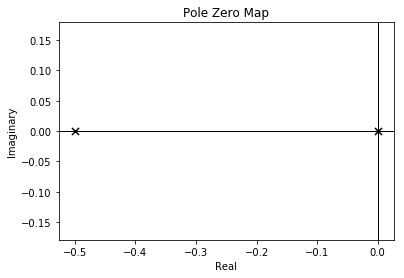

In [57]:
pzmap(sys)

Resposta ao degrau

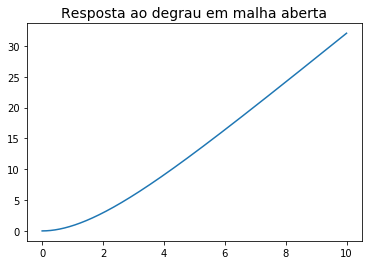

In [58]:
T = np.arange(0,10,0.001)
T, y = step_response(sys, T) 
plt.title("Resposta ao degrau em malha aberta", fontsize="14")
plt.plot(T, y)

### 2.2 Malha Fechada

In [59]:
sysmf_tf = sys / (1 + sys) 
sysmf_tf


        2 s^2 + s
------------------------
s^4 + s^3 + 2.25 s^2 + s

Polos e zeros

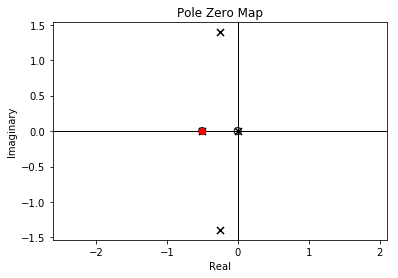

In [60]:
a = pzmap(sysmf_tf) 
plt.plot(a[1][0], a[1][1], 'or') 

Resposta ao degrau

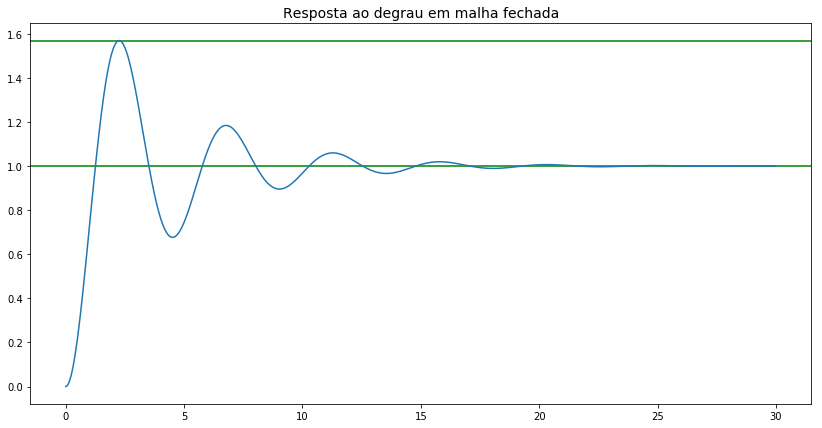

In [61]:
T = np.arange(0,30,.001)
T, y = step_response(sysmf_tf, T) 

plt.figure(figsize=(14, 7))

plt.axhline(y=y[-1], c='g') 
plt.axhline(y=y.max(), c='g') 

plt.title("Resposta ao degrau em malha fechada", fontsize="14")
plt.plot(T, y)

## Simulando com o Controlador PD

In [62]:
class PD(): 
  def __init__(self, kc: float, Td: float):
    self.kc, self.Td = kc, Td
    self.tf = tf([kc*Td, kc], [1]) # Define a transfer function

In [63]:
Ga = sys # FT de Malha Aberta
Ga


     2
-----------
s^2 + 0.5 s

A partir do que foi calculado pelo método frequencial, temos os coeficientes do controlador PD sendo:

In [64]:
tau_d

0.8617735167083429

In [65]:
kc[0]

0.828855494438983

In [66]:
type(np.float(kc[0]))

float

In [67]:
kc_ = np.float(kc[0])

In [68]:
pd = PD(kc=kc_, Td=tau_d) # Controlador 
print("FT do controlador PD")
Gc = pd.tf # Controlador 
Gc

FT do controlador PD



0.7143 s + 0.8289
-----------------
        1

### 2.3 Malha fechada com o controlador PD

In [69]:
GF = (Ga*Gc)/(1 + Ga*Gc) #Malha Fechada com controlador PD
GF


   1.429 s^3 + 2.372 s^2 + 0.8289 s
--------------------------------------
s^4 + 2.429 s^3 + 2.622 s^2 + 0.8289 s

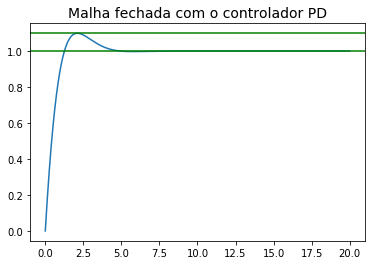

In [70]:
T = np.arange(0,20,.001)
T, y = step_response(GF, T) 
plt.plot(T, y)
plt.title("Malha fechada com o controlador PD", fontsize="14")
plt.axhline(y=y[-1], c='g') 
plt.axhline(y=y.max(), c='g') 

### 2.4 Malha aberta com o controlador PD

In [71]:
G = (Ga*Gc) #Malha aberta com controlador PD
G


1.429 s + 1.658
---------------
  s^2 + 0.5 s

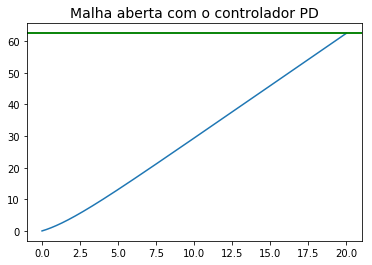

In [72]:
T = np.arange(0,20,.001)
T, y = step_response(G, T) 
plt.plot(T, y)
plt.title("Malha aberta com o controlador PD", fontsize="14")
plt.axhline(y=y[-1], c='g') 
plt.axhline(y=y.max(), c='g')

### Analisando os parâmetros frequenciais, considerando PD + sistema em malha aberta e fechada:

Relembrando, curvas de bode do **sistema**:

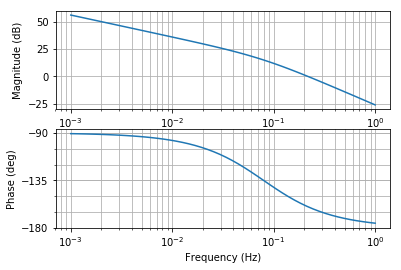

In [73]:
mag, phase, omega = bode(sys)

Agora, curvas de bode do **controlador PD**:

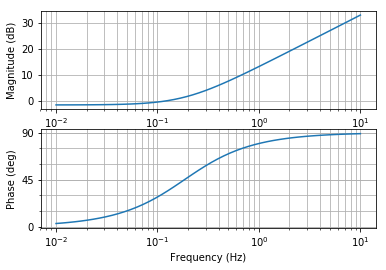

In [74]:
mag, phase, omega = bode(Gc)

Finalmente, curvas de bode do **controlador PD + sistema em malha fechada**:

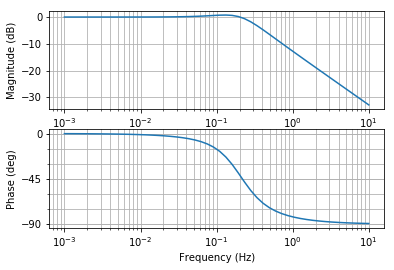

In [75]:
mag, phase, omega = bode(GF)

In [81]:
Ainda, parâmetros do **controlador PD + sistema em malha aberta**:

SyntaxError: invalid syntax (<ipython-input-81-21ecd9bad26d>, line 1)

Parâmetros frequenciais:

In [76]:
gm, pm, wg, wp = margin(GF)

In [77]:
gm

inf

In [78]:
pm

138.2766863073888

In [79]:
wg

nan

In [80]:
wp

1.27939460260879